In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import copy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [3]:
# Check if CUDA (GPU support) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Downloading and extracting the Food-101 dataset if not already present
if "food-101" in os.listdir():
    print("Dataset already exists.")
else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz > /dev/null 2>&1
    print("Extraction done!")

--2024-07-05 16:58:01--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2024-07-05 16:58:01--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: 'food-101.tar.gz'

food-101.tar.gz     100%[===================>]   4.65G   129MB/s    in 26s     

2024-07-05 16:58:27 (180 MB/s) - 'food-101.tar.gz' saved [4996278331/4996278331]

Dataset downloaded!
Extracting data..
Extraction done!


In [4]:
# Reading classes from classes.txt and selecting the first 20 classes and adding 'other'
classes = open("./food-101/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other']

# Reading and preparing train and test image paths and labels
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()
    img_path = "./food-101/images/"
    full_path = [os.path.join(img_path, img + ".jpg") for img in array]
    labels = [img.split('/')[0] for img in array]
    df = pd.DataFrame({'label': labels, 'path': full_path})
    df = shuffle(df)
    return df

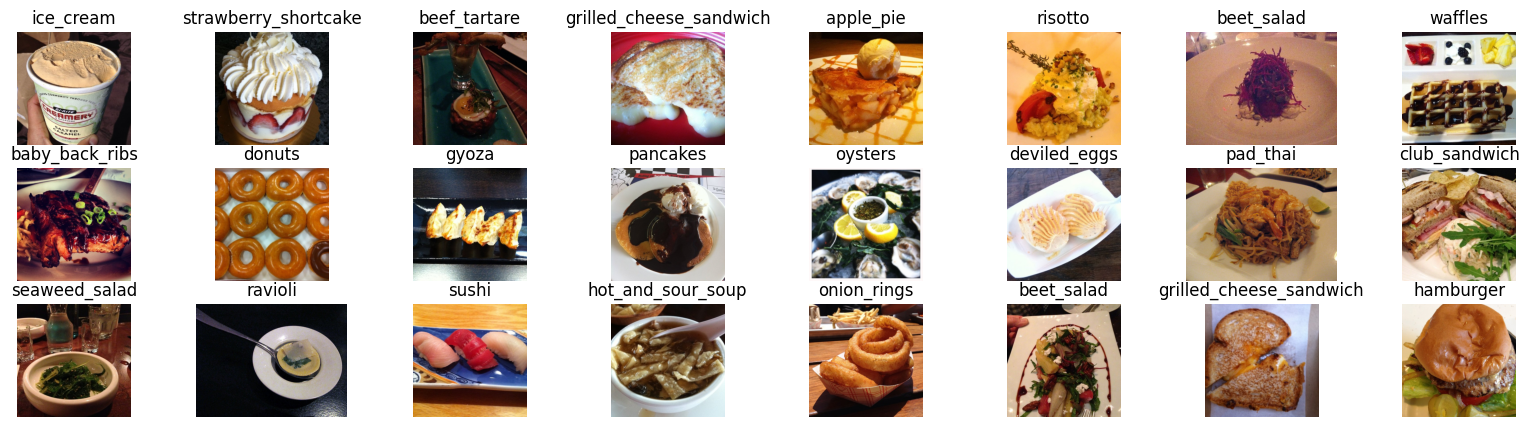

In [5]:
train_imgs = prep_df('./food-101/meta/train.txt')
test_imgs = prep_df('./food-101/meta/test.txt')

# Visualizing random images from the training dataset
plt.figure(figsize=(20, 5))
num_rows = 3
num_cols = 8
for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])
    label = train_imgs.label.iloc[random_idx]
    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

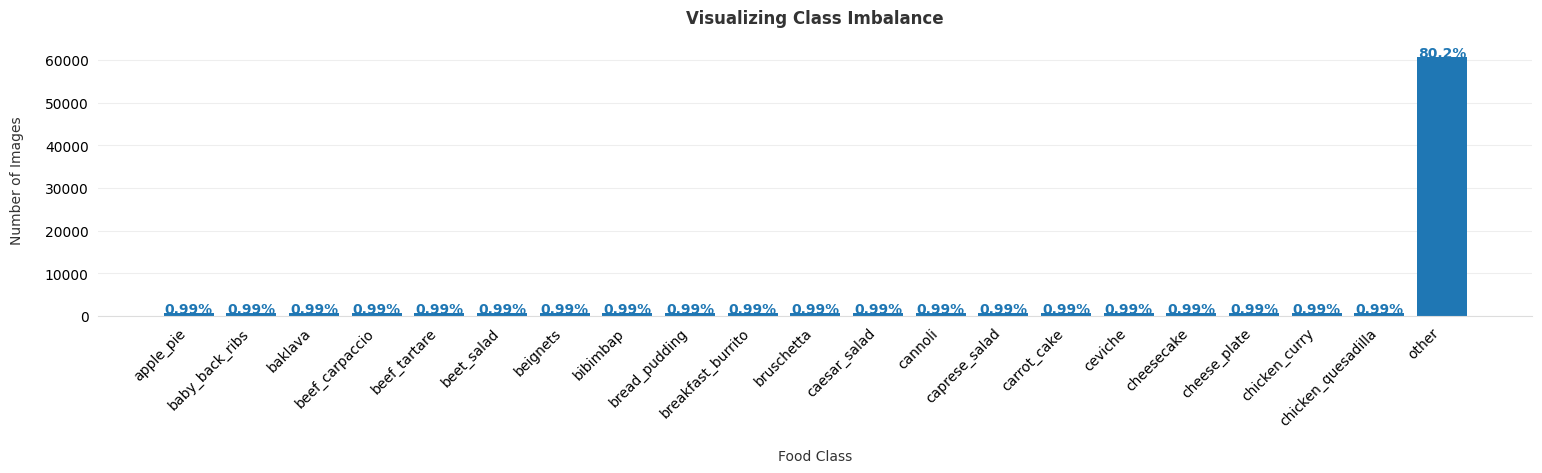

In [6]:
# Visualizing class distribution
def barplot_vis(imgs_dataframe):
    fig, ax = plt.subplots()
    new_labels = [row if row in classes_21 else "other" for row in imgs_dataframe.label]
    tmp_imgs_dataframe = copy.deepcopy(imgs_dataframe)
    tmp_imgs_dataframe['label'] = new_labels
    grouped_train_imgs = tmp_imgs_dataframe.groupby("label")
    heights = [grouped_train_imgs.get_group(group).shape[0] for group in classes_21]
    bars = ax.bar(x=classes_21, height=heights, tick_label=classes_21)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    bar_color = bars[0].get_facecolor()
    percentage_heights = np.array(heights) / sum(heights)
    for idx in range(len(bars)):
        ax.text(bars[idx].get_x() + bars[idx].get_width() / 2,
                bars[idx].get_height() + 0.3,
                f"{round(percentage_heights[idx] * 100, 2)}%",
                horizontalalignment='center',
                color=bar_color,
                weight='bold')

    ax.set_xlabel('Food Class', labelpad=15, color='#333333')
    ax.set_ylabel('Number of Images', labelpad=15, color='#333333')
    ax.set_title('Visualizing Class Imbalance', pad=15, color='#333333', weight='bold')
    fig.autofmt_xdate(rotation=45)
    fig.set_size_inches(18.5, 4)

barplot_vis(train_imgs)

In [7]:
# Data transforms for training and testing
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
# Encoding and decoding labels for the dataset
class LabelEncoder:
    def __init__(self, labels):
        self.labels = {label: idx for idx, label in enumerate(labels)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder = LabelEncoder(classes)

In [9]:
# Custom Dataset class for Food-101 dataset
class FoodDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 1]  # Path column
        image = Image.open(img_name).convert('RGB')

        label = encoder.get_idx(self.dataframe.iloc[idx, 0])  # Label column

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
# Creating datasets and dataloaders
train_dataset = FoodDataset(train_imgs, transform=train_transforms)
test_dataset = FoodDataset(test_imgs, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [11]:
# Loading pre-trained DenseNet-201 model
model = models.densenet201(pretrained=True)

# Modifying classifier for Food-101 dataset
model.classifier = nn.Sequential(
    nn.Linear(1920, 1024),
    nn.ReLU(),
    nn.Linear(1024, len(classes)),
)

# Moving model to GPU if available
model = model.to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 128MB/s] 


In [12]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    return train_loss, train_acc

In [14]:
# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = correct / total
    return test_loss, test_acc

In [ ]:
# Training and evaluation loop
num_epochs = 5
best_acc = 0.0
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    # Save the model if test accuracy improves
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(model.state_dict())

Epoch 1/5


 10%|█         | 60/592 [1:03:24<8:46:15, 59.35s/it]

In [ ]:
# Load the best model weights
model.load_state_dict(best_model_wts)

# Saving the best model
torch.save(model.state_dict(), "./food_classifier.pth")
print("Model saved successfully.")

In [ ]:
# Visual evaluation of the model
def visualize_predictions(model, dataset):
    model.eval()
    num_images = 18
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    fig, axs = plt.subplots(3, 6, figsize=(15, 8))
    fig.subplots_adjust(hspace=0.6, wspace=0.3)
    axs = axs.ravel()

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        image